In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import models
from keras import layers
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from geneticalgorithm import geneticalgorithm as ga
from matplotlib import pyplot as plt

2025-05-16 16:18:33.780001: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 16:18:33.788780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747405113.798103 1626345 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747405113.800957 1626345 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747405113.808633 1626345 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
print("GPU dostępny:", tf.config.list_physical_devices('GPU'))

GPU dostępny: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def get_rsfg(sis):
    
    num_cols = sis.shape[1]

    rsfg_columns = ["level", "relation", "support", "certainty", "coverage", "strength"]

    rsfg_df = pd.DataFrame(columns=rsfg_columns)

    for level in range(num_cols - 1):
        
        edge_counts = {}
        source_counts = {}
        target_counts = {}
        total_possible = len(sis.iloc[:, level + 1])
        
        for _, row in sis.iterrows():
            
            source = str(row.iloc[level])
            target = str(row.iloc[level + 1])
            key = (source, target)
            edge_counts[key] = edge_counts.get(key, 0) + 1
            source_counts[source] = source_counts.get(source, 0) + 1
            target_counts[target] = target_counts.get(target, 0) + 1
            
        for (source, target), count in edge_counts.items():
            
            cer = count / source_counts[source] if source_counts[source] else 0
            cov = count / target_counts[target] if target_counts[target] else 0
            str_value = count / total_possible if total_possible else 0
            lev = f"{level}<>{level+1}"
            rel = f"{source}-->{target}"
            
            new_row = pd.DataFrame(data=np.array([[lev, rel, count, f"{cer:.6f}", f"{cov:.6f}", f"{str_value:.6f}"]]), columns=rsfg_columns)
            
            rsfg_df = pd.concat([rsfg_df, new_row], ignore_index=True)

    return rsfg_df

In [4]:
(x_train_valid, y_train_valid), (x_test, y_test) = mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, stratify=y_train_valid)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train/255.0
x_valid = x_valid/255.0
x_test = x_test/255.0

y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

In [5]:
# TODO: ekesperymenty z ilością filtrow

n_filters_conv_1 = 4 # liczba filtrów w pierwszej warstwie konwolucyjnej
filter_size_conv_1 = 5 # rozmiar okienka konwolucji
n_filters_conv_2 = 4 # liczba filtrów w drugiej warstwie konwolucyjnej
filter_size_conv_2 = 5 # rozmiar okienka konwolucji
n_neurons_dense_1 = 50 # liczba neuronów w pierwszej warstwie gęstej
n_neurons_dense_2 = 10 # liczba neuronów w drugiej warstwie gęstej

n_epochs = 20 # liczba epok
batch_size = 256 # rozmiar paczki

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(n_filters_conv_1, (filter_size_conv_1, filter_size_conv_1), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
model.add(layers.Conv2D(n_filters_conv_2, (filter_size_conv_2, filter_size_conv_2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(n_neurons_dense_1, activation='relu'))
model.add(layers.Dense(n_neurons_dense_2, activation='softmax', dtype='float32'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

/home/maciej_stanislawski/miniconda3/envs/huretex/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747405115.865793 1626345 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43490 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 4)      │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 4)      │           404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        80,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,068 (316.67 KB)

 Trainable params: 81,068 (316.67 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
for layer in model.layers:
    print(f"{layer.name}: {layer.dtype}")

conv2d: float32
conv2d_1: float32
flatten: float32
dense: float32
dense_1: float32


In [9]:
for layer in model.layers:
    for weight in layer.weights:
        print(f"{weight.name} - dtype: {weight.dtype}")


kernel - dtype: float32
bias - dtype: float32
kernel - dtype: float32
bias - dtype: float32
kernel - dtype: float32
bias - dtype: float32
kernel - dtype: float32
bias - dtype: float32


In [10]:
print(x_train.dtype)

float32


In [11]:
history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(x_valid, y_valid), verbose=2)

Epoch 1/20


I0000 00:00:1747405116.836654 1627803 service.cc:152] XLA service 0x7f6a8c004c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747405116.836683 1627803 service.cc:160]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-05-16 16:18:36.852288: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747405116.919213 1627803 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747405118.831732 1627803 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-05-16 16:18:39.538826: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_363', 8 bytes spill stores, 8 bytes spill loads

2025-05-16 16:18:41.453807: I external/local_xla/xla

188/188 - 5s - 29ms/step - accuracy: 0.8938 - loss: 0.3595 - val_accuracy: 0.9479 - val_loss: 0.1909
Epoch 2/20
188/188 - 0s - 2ms/step - accuracy: 0.9605 - loss: 0.1302 - val_accuracy: 0.9538 - val_loss: 0.1527
Epoch 3/20
188/188 - 1s - 3ms/step - accuracy: 0.9725 - loss: 0.0891 - val_accuracy: 0.9767 - val_loss: 0.0838
Epoch 4/20
188/188 - 1s - 3ms/step - accuracy: 0.9790 - loss: 0.0688 - val_accuracy: 0.9706 - val_loss: 0.0974
Epoch 5/20
188/188 - 1s - 3ms/step - accuracy: 0.9828 - loss: 0.0558 - val_accuracy: 0.9722 - val_loss: 0.0918
Epoch 6/20
188/188 - 1s - 3ms/step - accuracy: 0.9852 - loss: 0.0467 - val_accuracy: 0.9787 - val_loss: 0.0761
Epoch 7/20
188/188 - 1s - 3ms/step - accuracy: 0.9879 - loss: 0.0385 - val_accuracy: 0.9797 - val_loss: 0.0716
Epoch 8/20
188/188 - 0s - 2ms/step - accuracy: 0.9896 - loss: 0.0319 - val_accuracy: 0.9801 - val_loss: 0.0770
Epoch 9/20
188/188 - 1s - 3ms/step - accuracy: 0.9911 - loss: 0.0279 - val_accuracy: 0.9793 - val_loss: 0.0773
Epoch 10/20

In [12]:
layer_outputs = [layer.output for layer in model.layers]
print("Input: ", model.layers[0].input.shape)
print("Output: ", layer_outputs)
activation_model = models.Model(inputs=model.layers[0].input, outputs=layer_outputs)

Input:  (None, 28, 28, 1)
Output:  [<KerasTensor shape=(None, 24, 24, 4), dtype=float32, sparse=False, name=keras_tensor_1>, <KerasTensor shape=(None, 20, 20, 4), dtype=float32, sparse=False, name=keras_tensor_3>, <KerasTensor shape=(None, 1600), dtype=float32, sparse=False, name=keras_tensor_6>, <KerasTensor shape=(None, 50), dtype=float32, sparse=False, name=keras_tensor_10>, <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_15>]


In [13]:
activations = activation_model.predict(x=x_train)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 358us/step


In [14]:
artifact_clusters = pd.DataFrame()
print(artifact_clusters)

Empty DataFrame
Columns: []
Index: []


## Zrównoleglone działanie

In [ ]:
import multiprocessing as mp

print(mp.cpu_count())

In [ ]:
from multiprocessing import Pool, cpu_count

def process_filter(f):
    print(f'filter: {f}')
    activations_f = activations[0][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0], activations_f.shape[1]*activations_f.shape[2]])
    print(f, activations_f[0, :10])
    ac_f = AgglomerativeClustering(n_clusters=10).fit(activations_f)
    return f, ac_f.labels_

with Pool(processes=640) as pool:
    results = pool.map(process_filter, range(n_filters_conv_1))

artifact_clusters = {'l0_f'+str(f): labels for f, labels in results}


In [ ]:
from joblib import Parallel, delayed
from sklearn.cluster import AgglomerativeClustering

def process_filter(f):
    print(f'filter: {f}')
    activations_f = activations[0][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0], activations_f.shape[1]*activations_f.shape[2]])
    ac_f = AgglomerativeClustering(n_clusters=10).fit(activations_f)
    print(f, activations_f[0, :3])
    return f, ac_f.labels_

results = Parallel(n_jobs=-1)(delayed(process_filter)(f) for f in range(n_filters_conv_1))
# results = Parallel(n_jobs=-1)(delayed(process_filter)(f) for f in range(Layers.conv_1['filters'] + Layers.conv_2['filters']))


# zapis wyników
# artifact_clusters = {'l0_f'+str(f): labels for f, labels in results}
# artifact_clusters['l0_f'+str(f)] = ac_f.labels_

for f, labels in results:
    artifact_clusters[f'l0_f{f}'] = labels

# for f, labels in results[4:]:
#     artifact_clusters[f'l1_f{f}'] = labels


# zrównoleglenie moje

In [15]:
from itertools import product

a = (0, 1)
b = (0, 1, 2, 3)

kombinacje = list(product(a, b))
print(kombinacje)


[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]


In [16]:
from joblib import Parallel, delayed
from sklearn.cluster import AgglomerativeClustering

def process_filter(l, f):
    print(f'filter: {f}')
    activations_f = activations[l][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0], activations_f.shape[1]*activations_f.shape[2]])
    ac_f = AgglomerativeClustering(n_clusters=10).fit(activations_f)
    print(f, activations_f[0, :3])
    return l, f, ac_f.labels_

results = Parallel(n_jobs=-1)(delayed(process_filter)(l, f) for l, f in kombinacje)
# results = Parallel(n_jobs=-1)(delayed(process_filter)(f) for f in range(Layers.conv_1['filters'] + Layers.conv_2['filters']))


# zapis wyników
# artifact_clusters = {'l0_f'+str(f): labels for f, labels in results}
# artifact_clusters['l0_f'+str(f)] = ac_f.labels_

for l, f, labels in results:
    artifact_clusters[f'l{l}_f{f}'] = labels

# for f, labels in results[4:]:
#     artifact_clusters[f'l1_f{f}'] = labels

filter: 2
filter: 0
filter: 3
filter: 1
filter: 0
filter: 2
filter: 1
filter: 3
2 [0.05396342 0.         0.        ]
3 [0.13698274 0.07906268 0.0121202 ]
0 [0.19294798 0.27117062 0.17051104]
1 [0.03852926 0.03852926 0.03852926]
0 [0.0526806 0.0526806 0.0526806]
2 [0.06758941 0.06758941 0.06758941]
1 [0. 0. 0.]
3 [0.05255148 0.05255148 0.05255148]


## Niezrównoleglone działanie

In [ ]:
for f in range(n_filters_conv_1):

    print('filter: '+str(f))

    activations_f = activations[0][:,:,:,f]
    print(activations_f.shape)
    activations_f = activations_f.reshape([activations_f.shape[0],activations_f.shape[1]*activations_f.shape[2]])
    print(activations_f.shape)
    ac_f = AgglomerativeClustering(n_clusters=10).fit(activations_f)

    artifact_clusters['l0_f'+str(f)] = ac_f.labels_

In [ ]:
for f in range(n_filters_conv_2):

    print('filter: '+str(f))

    activations_f = activations[1][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0],activations_f.shape[1]*activations_f.shape[2]])
    ac_f = AgglomerativeClustering(n_clusters=10).fit(activations_f)

    artifact_clusters['l1_f'+str(f)] = ac_f.labels_

### Warstwy aktywacji

In [17]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3
0          5      1      6      6      6      6      2      4
1          6      2      2      0      2      5      3      2
2          0      1      6      6      4      0      2      8
3          0      1      6      6      6      0      1      4
4          0      1      1      5      4      1      1      7
...      ...    ...    ...    ...    ...    ...    ...    ...
47995      3      0      4      4      1      7      6      3
47996      8      4      3      2      5      9      7      6
47997      0      1      1      5      8      0      1      8
47998      6      2      0      3      0      0      3      7
47999      0      1      1      5      9      0      1      1

[48000 rows x 8 columns]


In [18]:
activations_d_1 = activations[3]
ac_d = AgglomerativeClustering(n_clusters=10).fit(activations_d_1)
artifact_clusters['l3'] = ac_d.labels_

In [19]:
# TODO: czy brac oryginalne predykcje czy wyniki modelu?

predictions = model.predict(x=x_train)
pred = np.argmax(predictions, axis=1)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 315us/step


In [21]:
predictions.shape

(48000, 10)

In [22]:
a = [p for p in pred if p == 8]

print(a)
print(len(a))


[np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8)

In [23]:
artifact_clusters['p'] = pred

In [24]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3  l3  p
0          5      1      6      6      6      6      2      4   7  7
1          6      2      2      0      2      5      3      2   6  6
2          0      1      6      6      4      0      2      8   9  9
3          0      1      6      6      6      0      1      4   4  4
4          0      1      1      5      4      1      1      7   4  4
...      ...    ...    ...    ...    ...    ...    ...    ...  .. ..
47995      3      0      4      4      1      7      6      3   0  3
47996      8      4      3      2      5      9      7      6   3  1
47997      0      1      1      5      8      0      1      8   9  9
47998      6      2      0      3      0      0      3      7   6  6
47999      0      1      1      5      9      0      1      1   7  7

[48000 rows x 10 columns]


### Generate artifact_clusters for just one class

In [25]:
e_artifact_clusters = artifact_clusters[artifact_clusters['p'] == 2]

In [26]:
print(e_artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3  l3  p
19         4      6      0      1      0      4      5      0   1  2
41         4      6      0      1      2      4      9      0   1  2
70         4      0      7      0      2      2      5      0   1  2
88         0      6      0      1      2      4      8      0   1  2
89         4      6      0      1      2      4      2      6   1  2
...      ...    ...    ...    ...    ...    ...    ...    ...  .. ..
47888      0      6      6      1      0      4      2      1   1  2
47910      4      6      0      1      2      8      5      0   1  2
47947      0      6      6      1      4      1      2      1   1  2
47984      4      6      0      1      0      4      9      0   1  2
47987      4      6      0      1      2      4      9      0   1  2

[4772 rows x 10 columns]


## Twin (readable)

In [27]:
sis = pd.DataFrame()

In [28]:
sis['conv1'] = e_artifact_clusters.astype(str).loc[:,['l0_f0', 'l0_f1', 'l0_f2', 'l0_f3']].apply('_'.join, axis=1)

In [29]:
sis['conv2'] = e_artifact_clusters.astype(str).loc[:,['l1_f0', 'l1_f1', 'l1_f2', 'l1_f3']].apply('_'.join, axis=1)

In [30]:
sis['dense1'] = e_artifact_clusters['l3']

In [31]:
sis['output'] = e_artifact_clusters['p']

In [32]:
print(sis)

         conv1    conv2  dense1  output
19     4_6_0_1  0_4_5_0       1       2
41     4_6_0_1  2_4_9_0       1       2
70     4_0_7_0  2_2_5_0       1       2
88     0_6_0_1  2_4_8_0       1       2
89     4_6_0_1  2_4_2_6       1       2
...        ...      ...     ...     ...
47888  0_6_6_1  0_4_2_1       1       2
47910  4_6_0_1  2_8_5_0       1       2
47947  0_6_6_1  4_1_2_1       1       2
47984  4_6_0_1  0_4_9_0       1       2
47987  4_6_0_1  2_4_9_0       1       2

[4772 rows x 4 columns]


In [33]:
def get_rsfg(sis):
    
    num_cols = sis.shape[1]

    rsfg_columns = ["level", "relation", "support", "certainty", "coverage", "strength"]

    rsfg_df = pd.DataFrame(columns=rsfg_columns)

    for level in range(num_cols - 1):
        
        edge_counts = {}
        source_counts = {}
        target_counts = {}
        total_possible = len(sis.iloc[:, level + 1])
        
        for _, row in sis.iterrows():
            
            source = str(row.iloc[level])
            target = str(row.iloc[level + 1])
            key = (source, target)
            edge_counts[key] = edge_counts.get(key, 0) + 1
            source_counts[source] = source_counts.get(source, 0) + 1
            target_counts[target] = target_counts.get(target, 0) + 1
            
        for (source, target), count in edge_counts.items():
            
            cer = count / source_counts[source] if source_counts[source] else 0
            cov = count / target_counts[target] if target_counts[target] else 0
            str_value = count / total_possible if total_possible else 0
            lev = f"{level}<>{level+1}"
            rel = f"{source}-->{target}"
            
            new_row = pd.DataFrame(data=np.array([[lev, rel, count, f"{cer:.6f}", f"{cov:.6f}", f"{str_value:.6f}"]]), columns=rsfg_columns)
            
            rsfg_df = pd.concat([rsfg_df, new_row], ignore_index=True)

    return rsfg_df

In [34]:
rsfg = get_rsfg(sis)

In [35]:
print(rsfg)

     level           relation support certainty  coverage  strength
0     0<>1  4_6_0_1-->0_4_5_0     361  0.095604  0.986339  0.075650
1     0<>1  4_6_0_1-->2_4_9_0     440  0.116525  0.964912  0.092205
2     0<>1  4_0_7_0-->2_2_5_0       1  0.500000  0.200000  0.000210
3     0<>1  0_6_0_1-->2_4_8_0       2  0.015625  1.000000  0.000419
4     0<>1  4_6_0_1-->2_4_2_6       2  0.000530  1.000000  0.000419
...    ...                ...     ...       ...       ...       ...
1255  2<>3              8-->2      18  1.000000  0.003772  0.003772
1256  2<>3              3-->2       5  1.000000  0.001048  0.001048
1257  2<>3              0-->2      14  1.000000  0.002934  0.002934
1258  2<>3              2-->2       3  1.000000  0.000629  0.000629
1259  2<>3              6-->2       2  1.000000  0.000419  0.000419

[1260 rows x 6 columns]


In [36]:
rsfg['confidence'] = 2*rsfg['certainty'].astype(float)*rsfg['coverage'].astype(float)/(rsfg['certainty'].astype(float)+rsfg['coverage'].astype(float))

In [37]:
print(rsfg)

     level           relation support certainty  coverage  strength  \
0     0<>1  4_6_0_1-->0_4_5_0     361  0.095604  0.986339  0.075650   
1     0<>1  4_6_0_1-->2_4_9_0     440  0.116525  0.964912  0.092205   
2     0<>1  4_0_7_0-->2_2_5_0       1  0.500000  0.200000  0.000210   
3     0<>1  0_6_0_1-->2_4_8_0       2  0.015625  1.000000  0.000419   
4     0<>1  4_6_0_1-->2_4_2_6       2  0.000530  1.000000  0.000419   
...    ...                ...     ...       ...       ...       ...   
1255  2<>3              8-->2      18  1.000000  0.003772  0.003772   
1256  2<>3              3-->2       5  1.000000  0.001048  0.001048   
1257  2<>3              0-->2      14  1.000000  0.002934  0.002934   
1258  2<>3              2-->2       3  1.000000  0.000629  0.000629   
1259  2<>3              6-->2       2  1.000000  0.000419  0.000419   

      confidence  
0       0.174312  
1       0.207939  
2       0.285714  
3       0.030769  
4       0.001059  
...          ...  
1255    0.0075

In [38]:
levels = rsfg['level'].unique()
print(levels)

['0<>1' '1<>2' '2<>3']


In [39]:
rsfg_layers = list()
node_dicts = list()

for level in levels:

    layer = rsfg.loc[rsfg['level']==level,:]
    layer[['source', 'target']] = layer['relation'].str.split('-->', expand=True)

    if len(node_dicts)==0:
        
        node_dict_1 = {key: i for i, key in enumerate(layer['source'].unique())}
        node_dicts.append(node_dict_1)

        layer['source_id'] = layer['source'].map(node_dict_1)

    else:

        layer['source_id'] = layer['source'].map(node_dicts[-1])        

    node_dict_2 = {key: i for i, key in enumerate(layer['target'].unique())}
    node_dicts.append(node_dict_2)

    layer['target_id'] = layer['target'].map(node_dict_2)
    
    layer = layer[['source_id', 'target_id', 'source', 'target', 'confidence']]
        
    rsfg_layers.append(layer)

/tmp/ipykernel_1626345/1748982612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer[['source', 'target']] = layer['relation'].str.split('-->', expand=True)
/tmp/ipykernel_1626345/1748982612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer[['source', 'target']] = layer['relation'].str.split('-->', expand=True)
/tmp/ipykernel_1626345/1748982612.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

## Genetic Algorithm

https://pypi.org/project/geneticalgorithm/

In [40]:
def fitness(x):

    confidences = list()

    for i in range(len(x)-1):

        layer = rsfg_layers[i]

        confidence = layer.loc[(layer['source_id']==x[i]) & (layer['target_id']==x[i+1]), ['confidence']]

        if len(confidence)==0:

            return 0
            
        confidences.append(confidence['confidence'])

    return -np.min(np.array(confidences))  

[[0, 149], [0, 420], [0, 8], [0, 0]]
 The best solution found:                                                                           
 [ 2. 27.  0.  0.]

 Objective function:
 -0.06815827336804298


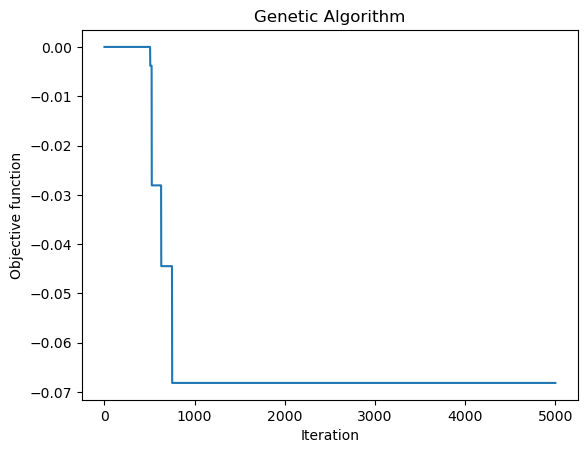

In [41]:
parameters = {'max_num_iteration': 5000,
              'population_size': 20,
              'parents_portion': 0.3,
              'mutation_probability':0.1,
              'crossover_probability': 0.1,
              'elit_ratio': 0.01,
              'crossover_type':'uniform',
              'max_iteration_without_improv': None}


varbounds = []

for d in node_dicts:

    varbounds.append([0,len(d)-1])

print(varbounds)

gen_alg = ga(function=fitness, dimension=len(varbounds), variable_type='int', variable_boundaries=np.array(varbounds), algorithm_parameters=parameters)

gen_alg.run()

In [42]:
best_path = gen_alg.output_dict['variable']

In [43]:
best_path_info = pd.DataFrame(columns=['confidence', 'source', 'target'])

for i in range(len(best_path)-1):

        layer = rsfg_layers[i]

        path_info = layer.loc[(layer['source_id']==best_path[i]) & (layer['target_id']==best_path[i+1]), ['confidence', 'source', 'target']]
    
        best_path_info = pd.concat([best_path_info.dropna(axis=1, how='all') , path_info], ignore_index=True)

print(best_path_info)

   confidence   source   target
0    0.183051  0_6_0_1  0_4_2_0
1    0.068158  0_4_2_0        1
2    0.992824        1        2


## Visualization

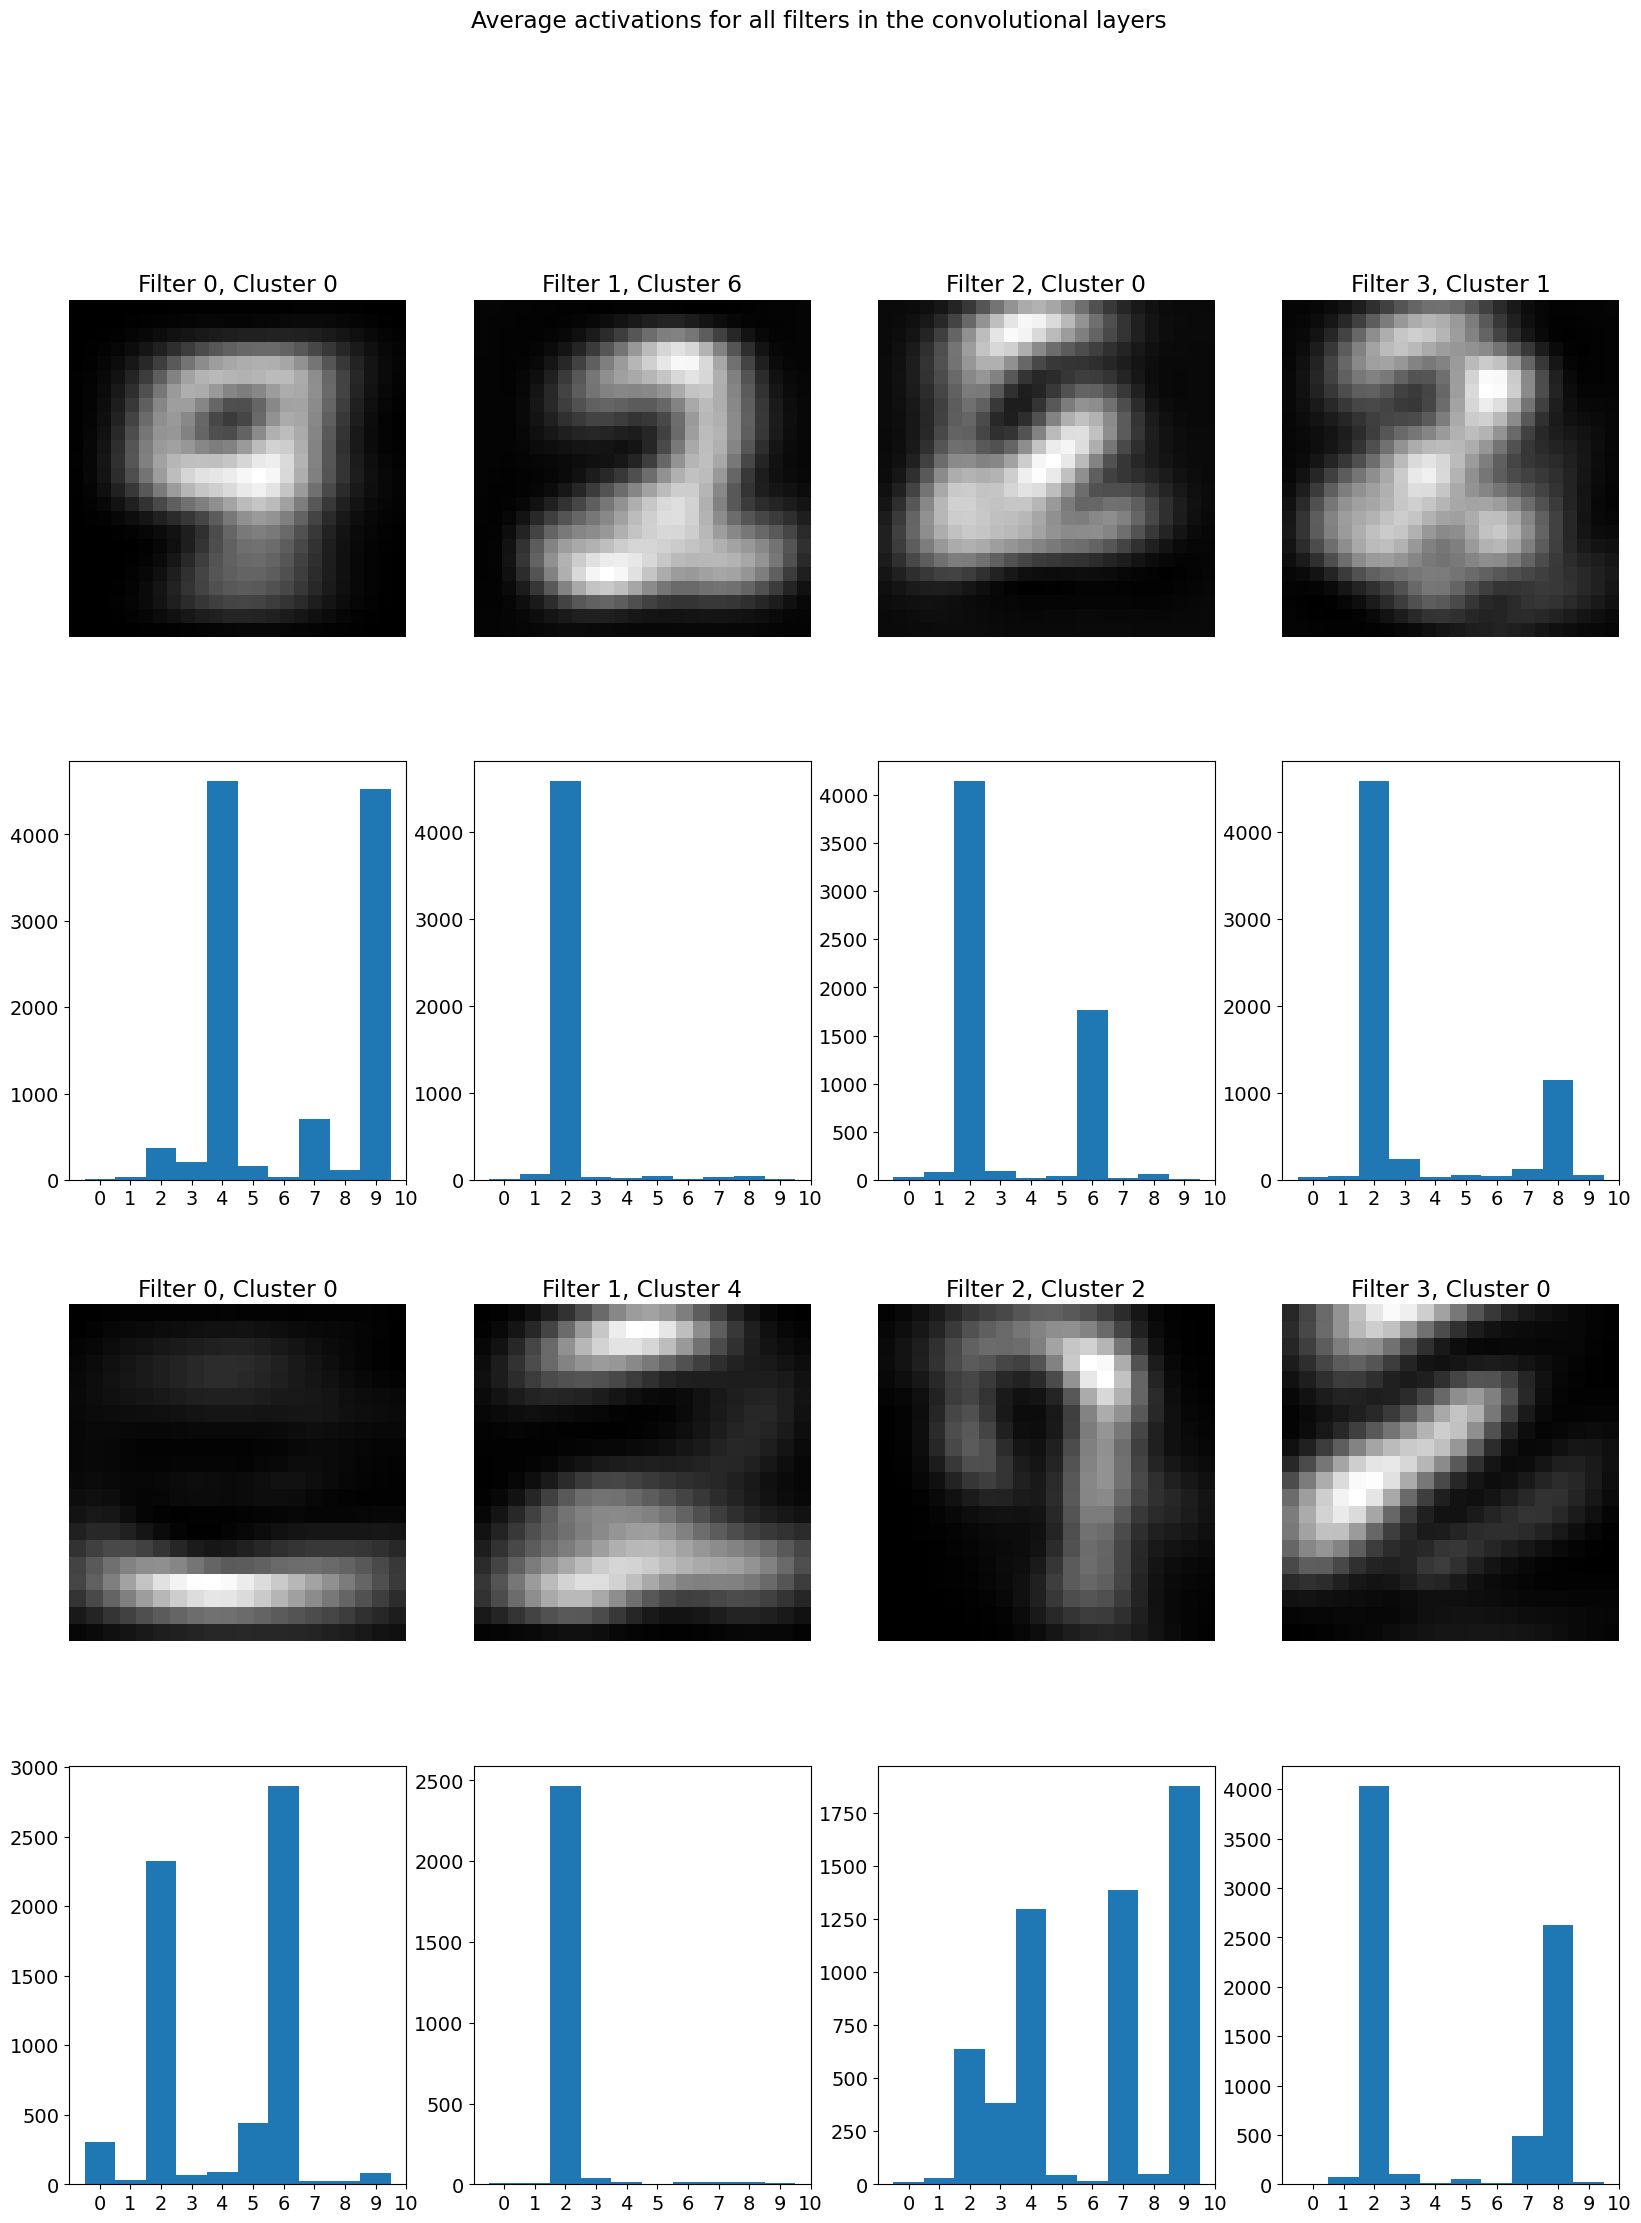

In [44]:
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(4, 4, figsize=(20, 25)) 
fig.suptitle("Average activations for all filters in the convolutional layers")

source_cluster_indexes = best_path_info.loc[:,'source'].str.split('_')
target_cluster_indexes = best_path_info.loc[:,'target'].str.split('_')

row = 0

for filter_index in range(4):

    source_cluster_index = int(source_cluster_indexes[0][filter_index])
    target_cluster_index = int(target_cluster_indexes[0][filter_index])
    
    activation_data_0 = activations[0][artifact_clusters[f'l0_f{filter_index}'] == source_cluster_index, :, :, filter_index]
    cluster_0 = artifact_clusters.loc[artifact_clusters[f'l0_f{filter_index}'] == source_cluster_index, :]

    activation_data_1 = activations[1][artifact_clusters[f'l1_f{filter_index}'] == target_cluster_index, :, :, filter_index]
    cluster_1= artifact_clusters.loc[artifact_clusters[f'l1_f{filter_index}'] == target_cluster_index, :]

    average_activation_0 = np.mean(activation_data_0, axis=0)
    average_activation_1 = np.mean(activation_data_1, axis=0)

    col = filter_index
            
    axes[2*row, col].imshow(average_activation_0, cmap=plt.get_cmap('gray'))
    axes[2*row, col].axis("off")
    axes[2*row, col].set_title(f"Filter {filter_index}, Cluster {source_cluster_index}")

    bins = np.arange(0, 9 + 1.5) - 0.5
    axes[2*row+1, col].hist(cluster_0['p'], bins)
    axes[2*row+1, col].set_xticks(bins + 0.5)

    axes[2*row+2, col].imshow(average_activation_1, cmap=plt.get_cmap('gray'))
    axes[2*row+2, col].axis("off")
    axes[2*row+2, col].set_title(f"Filter {filter_index}, Cluster {target_cluster_index}")

    bins = np.arange(0, 9 + 1.5) - 0.5
    axes[2*row+3, col].hist(cluster_1['p'], bins)
    axes[2*row+3, col].set_xticks(bins + 0.5)

plt.show()

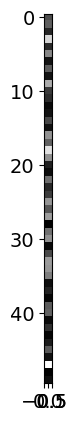

In [45]:
activation_data_3 = activations[3][artifact_clusters[f'l0_f{filter_index}'] == source_cluster_index, :]
activation_data_3 = np.mean(activation_data_3, axis=0)
plt.imshow(activation_data_3.reshape(activation_data_3.shape[0], 1, 1), cmap=plt.get_cmap('gray'))